In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, initializers
import random
import time
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1);
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1);
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1];
    return adj_matrix

def l2_loss(logits, labels, mask):
    # use l_2 loss (regression loss)
    #loss = tf.losses.mean_squared_error (labels, logits)
    #loss = tf.nn.l2_loss(labels - logits)
    loss = tf.math.square(tf.norm(labels - logits, axis=1, ord=2))/2
    # taking mean over the number of traning data
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)
c = 100
def generateAdj(N, p1, p2):
    adj_matrix = np.eye(N)
    for i in range(N-1):
        for j in range(N-i-1):
            if i < c:
                adj_matrix[i,i+j+1] = np.random.binomial(1,p1, 1)
            else:
                adj_matrix[i, i + j + 1] = np.random.binomial(1, p2, 1)
            adj_matrix[i+j+1,i] = adj_matrix[i,i+j+1]
    return adj_matrix

def generate_norm_adj_matrix(adj_matrix):
    adj_matrix = adj_matrix.astype('float32')
    deg_matrix = tf.reduce_sum(adj_matrix, axis=-1)
    deg_group = np.array([tf.reduce_mean(deg_matrix[0:tf.cast(c-1, tf.int32)]), tf.reduce_mean(deg_matrix[tf.cast(N-c, tf.int32): N-1])])
    norm_deg_matrix = tf.linalg.diag(1.0 / tf.sqrt(deg_matrix))
    norm_adj_matrix = tf.matmul(norm_deg_matrix, tf.matmul(adj_matrix, norm_deg_matrix))
    return norm_adj_matrix

def generateWeight(mu, sigma, d, P):
    # W d*P
    return np.random.normal(mu, sigma, (d, P))

def generateVeight(mu, sigma, K, P):
    # V d*P
    return np.random.normal(mu, sigma, (K, P))

def generateC(mu, sigma, P, K):
    # C P*K
    return np.random.normal(mu, sigma, (P, K))

def generateX(mu, sigma, N, d):
    return np.random.normal(mu, sigma, (N, d))

def generate_data(A_star, X, W, V, C, alpha):
    # A_star N*N, X N*d, W d*p, V K*p, C p*K,
    # node_labels = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(X, W))),
    #                            np.tanh(tf.matmul(A_star, tf.matmul(X, W)))), C)
    # node_labels_F = np.matmul(np.sin(tf.matmul(A_star, tf.matmul(X, W))), C) # N*k
    # pow(tf.matmul(A_star, tf.matmul(node_labels_F, V)), 10)
    # # node_labels_G_F = np.matmul(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))), C) #N*k
    # node_labels_G_F = np.matmul(tf.matmul(A_star, tf.matmul(node_labels_F, V))**10, C) #N*k
    # node_labels_H = node_labels_F+ alpha * node_labels_G_F

    node_labels_F = np.matmul(tf.matmul(A_star, tf.matmul(X, W)), C) # N*k
    node_labels_G_F = np.matmul(np.multiply(np.sin(tf.matmul(A_star, tf.matmul(node_labels_F, V))),
                                               np.tanh(tf.matmul(A_star, tf.matmul(node_labels_F, V)))), C)
    node_labels_H = node_labels_F+ alpha * node_labels_G_F
    return node_labels_H

def createMask(index, N):
    mask = np.zeros(N)
    for i in index:
        mask[i] = 1
    return mask

In [3]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate)

def run_optimization(node_features, node_labels, A_star, test_error):
    # Wrap computation inside a GradientTape for automatic differentiation.
    index_batch = set(random.sample(train_index, batch_size))
    train_mask = createMask(index_batch, N)
    # 产生batch数量相对应的mask矩阵
    with tf.GradientTape() as t:
        # Forward pass.
        logits = cora_gnn(node_features, A_star)
        # Compute loss.
        loss = l2_loss(logits, node_labels, train_mask) #train_mask

    # Variables to update, i.e. trainable variables.
    variables = t.watched_variables()

    # Compute gradients.
    gradients = t.gradient(loss, variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, variables))
    val_mse = l2_loss(logits, node_labels, val_mask)
    test_mse = l2_loss(logits, node_labels, test_mask)
    test_error.append(test_mse)
    if epoch % 500 == 0:
        print('Iteration', epoch, '| Training loss:', loss.numpy(), '| Val MSE:'
                      , val_mse.numpy(), '| Test MSE', test_mse.numpy())

In [5]:
N = 2000
m = 100
d = 10
P = 10
K = 2
mu = 0
sigma = 1

W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

In [6]:
# N=500, A = 2.5

In [8]:
train_size = int(N*0.25)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_500_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.3908243

Iteration 0 | Training loss: 12.662962 | Val MSE: 11.835164 | Test MSE 12.097053
Iteration 500 | Training loss: 0.8128103 | Val MSE: 0.793155 | Test MSE 0.7892317
Iteration 1000 | Training loss: 0.4919023 | Val MSE: 0.584277 | Test MSE 0.59021556
Iteration 1500 | Training loss: 0.6277887 | Val MSE: 0.4031319 | Test MSE 0.424774
Iteration 2000 | Training loss: 0.330693 | Val MSE: 0.3197141 | Test MSE 0.3440304
Iteration 2500 | Training loss: 0.2588489 | Val MSE: 0.27855134 | Test MSE 0.30166844


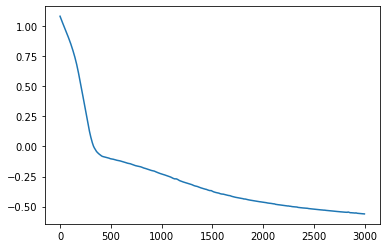

In [9]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_500_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_500_A1, A_star, test_error_500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1), label='test_error_500_A1')

In [ ]:
learning_rate = 1e-2
epochs = 2000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_500_A1, A_star, test_error_500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A1), label='test_error_20_A1')

In [ ]:
#N=800,A=2.4

In [120]:
train_size = 800


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_800_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.3970232

Iteration 0 | Training loss: 1.2129604 | Val MSE: 0.9527037 | Test MSE 1.0616024
Iteration 500 | Training loss: 0.017696563 | Val MSE: 0.021162668 | Test MSE 0.024480833
Iteration 1000 | Training loss: 0.012102404 | Val MSE: 0.018003713 | Test MSE 0.020542951
Iteration 1500 | Training loss: 0.012256802 | Val MSE: 0.015973033 | Test MSE 0.018105034
Iteration 2000 | Training loss: 0.010124374 | Val MSE: 0.01399734 | Test MSE 0.01599197
Iteration 2500 | Training loss: 0.012648213 | Val MSE: 0.012169847 | Test MSE 0.0138993375


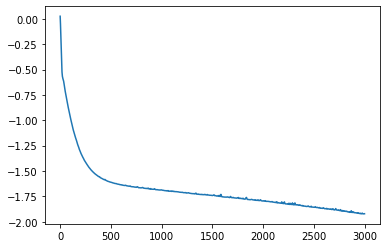

In [121]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_800_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_800_A1, A_star, test_error_800_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_800_A1), label='test_error_800_A1')

In [ ]:
# N=1000, A=2.1

In [12]:
train_size = int(N*0.5)

batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)

random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

alpha = 10
node_labels_1000_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.3978915

Iteration 0 | Training loss: 2.168851 | Val MSE: 2.3260286 | Test MSE 2.1178799
Iteration 500 | Training loss: 0.25686395 | Val MSE: 0.15487616 | Test MSE 0.15339969
Iteration 1000 | Training loss: 0.14424145 | Val MSE: 0.13899188 | Test MSE 0.13556214
Iteration 1500 | Training loss: 0.121857435 | Val MSE: 0.13077131 | Test MSE 0.12700991
Iteration 2000 | Training loss: 0.10651677 | Val MSE: 0.12340461 | Test MSE 0.11843547
Iteration 2500 | Training loss: 0.09074418 | Val MSE: 0.11590404 | Test MSE 0.10982889


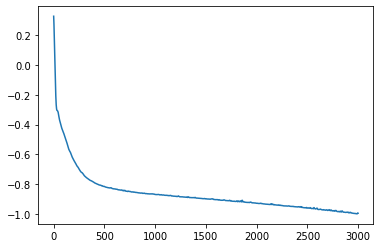

In [13]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1000_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1000_A1, A_star, test_error_1000_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A1), label='test_error_1000_A1')

In [79]:
N=2000
train_size = int(N*0.3)

batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)

random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

alpha = 10
node_labels_1500_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.396648

Iteration 0 | Training loss: 0.20584036 | Val MSE: 0.27547622 | Test MSE 0.28148383
Iteration 500 | Training loss: 0.0094792135 | Val MSE: 0.011975683 | Test MSE 0.013486895
Iteration 1000 | Training loss: 0.0128779495 | Val MSE: 0.010129669 | Test MSE 0.011459107
Iteration 1500 | Training loss: 0.0097467005 | Val MSE: 0.008973481 | Test MSE 0.009990924
Iteration 2000 | Training loss: 0.007951456 | Val MSE: 0.0075736693 | Test MSE 0.008551609
Iteration 2500 | Training loss: 0.005189459 | Val MSE: 0.006433356 | Test MSE 0.0072166054


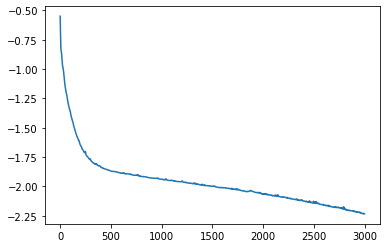

In [80]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1500_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1500_A1, A_star, test_error_1500_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1500_A1), label='test_error_1500_A1')

In [ ]:
#N=1800 A=2.4

In [81]:
train_size = int(N*0.6)

batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)

random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
val_size = int((N - train_size) / 2)
test_index.difference_update(train_index)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')

adj_matrix = generateAdj(N, 0.8, 0.1)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix

X = node_features
W = generateWeight(mu, sigma, d, P)
W = W.astype('float32')
C = generateC(mu, sigma, P, K)
C = C.astype('float32')
V = generateVeight(mu, sigma, K, P)
V = V.astype('float32')

alpha = 10
node_labels_1800_A1 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.3866398

Iteration 0 | Training loss: 0.54446703 | Val MSE: 0.6746005 | Test MSE 0.5966818
Iteration 500 | Training loss: 0.009264015 | Val MSE: 0.014091601 | Test MSE 0.012561862
Iteration 1000 | Training loss: 0.009777226 | Val MSE: 0.011722457 | Test MSE 0.010684025
Iteration 1500 | Training loss: 0.01063966 | Val MSE: 0.010254763 | Test MSE 0.009552939
Iteration 2000 | Training loss: 0.006867144 | Val MSE: 0.008860841 | Test MSE 0.007910802
Iteration 2500 | Training loss: 0.0050681736 | Val MSE: 0.0074094855 | Test MSE 0.0066764546


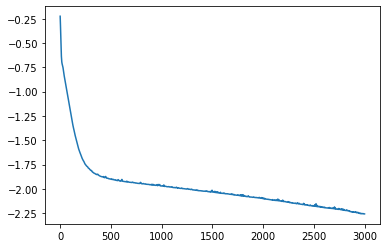

In [82]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1800_A1 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1800_A1, A_star, test_error_1800_A1)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1800_A1), label='test_error_1800_A1')

In [ ]:
#N=500, A=1.1

In [27]:
train_size = int(N*0.25)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_500_A2 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.135402

Iteration 0 | Training loss: 5.4038887 | Val MSE: 5.403667 | Test MSE 5.4493055
Iteration 500 | Training loss: 0.049049284 | Val MSE: 0.05260281 | Test MSE 0.048557173
Iteration 1000 | Training loss: 0.03050996 | Val MSE: 0.038778715 | Test MSE 0.036719706
Iteration 1500 | Training loss: 0.029990064 | Val MSE: 0.03380195 | Test MSE 0.032840677
Iteration 2000 | Training loss: 0.034546968 | Val MSE: 0.032902688 | Test MSE 0.032402694
Iteration 2500 | Training loss: 0.033071123 | Val MSE: 0.031669244 | Test MSE 0.031410877


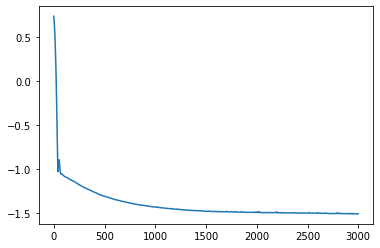

In [28]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_500_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_500_A2, A_star, test_error_500_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A2), label='test_error_500_A2')

In [ ]:
#N=800,A=1.1

In [107]:
train_size = 800


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_800_A2 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.1382859

Iteration 0 | Training loss: 1.3160573 | Val MSE: 1.2537814 | Test MSE 1.2348822
Iteration 500 | Training loss: 0.0060181827 | Val MSE: 0.0063399067 | Test MSE 0.0066073323
Iteration 1000 | Training loss: 0.0031571724 | Val MSE: 0.0038877458 | Test MSE 0.0038561116
Iteration 1500 | Training loss: 0.0034858333 | Val MSE: 0.0036450552 | Test MSE 0.0035774312
Iteration 2000 | Training loss: 0.0025267447 | Val MSE: 0.003493586 | Test MSE 0.0034315945
Iteration 2500 | Training loss: 0.0026492977 | Val MSE: 0.0032851754 | Test MSE 0.0032115562


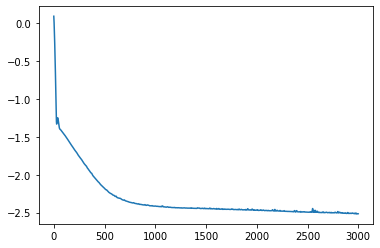

In [108]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 0.1
test_error_800_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_800_A2, A_star, test_error_800_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_800_A2), label='test_error_800_A2')

In [29]:
#N=1000,A=1.1

In [44]:
train_size = int(N*0.5)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1000_A2 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.1293275

Iteration 0 | Training loss: 0.3562059 | Val MSE: 0.37741578 | Test MSE 0.37853852
Iteration 500 | Training loss: 0.009308661 | Val MSE: 0.010844599 | Test MSE 0.011959925
Iteration 1000 | Training loss: 0.007798405 | Val MSE: 0.0071997014 | Test MSE 0.007873798
Iteration 1500 | Training loss: 0.008480254 | Val MSE: 0.006789203 | Test MSE 0.0073652905
Iteration 2000 | Training loss: 0.008812689 | Val MSE: 0.0070185787 | Test MSE 0.007272805
Iteration 2500 | Training loss: 0.008037864 | Val MSE: 0.006991107 | Test MSE 0.007739969


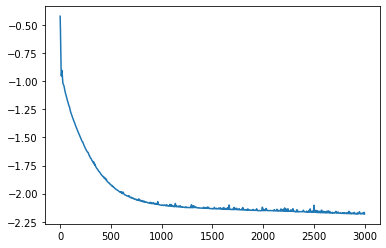

In [45]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 0.1
test_error_1000_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1000_A2, A_star, test_error_1000_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A2), label='test_error_1000_A2')

In [ ]:
#N=1500,A=1.1

In [83]:
train_size = int(N*0.3)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1500_A2 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.1351804

Iteration 0 | Training loss: 0.054895483 | Val MSE: 0.053050134 | Test MSE 0.05283994
Iteration 500 | Training loss: 0.00061603653 | Val MSE: 0.00035033876 | Test MSE 0.00039663978
Iteration 1000 | Training loss: 0.000179279 | Val MSE: 0.00024351248 | Test MSE 0.00027344824
Iteration 1500 | Training loss: 0.0001995863 | Val MSE: 0.00020369861 | Test MSE 0.00022329183
Iteration 2000 | Training loss: 0.00015219286 | Val MSE: 0.00017962354 | Test MSE 0.00019274377
Iteration 2500 | Training loss: 0.000105348256 | Val MSE: 0.00016729394 | Test MSE 0.000174782


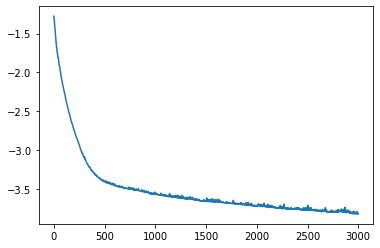

In [84]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1500_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1500_A2, A_star, test_error_1500_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.8
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1500_A2), label='test_error_1500_A2')

In [ ]:
#N=1800, A=1.1

In [94]:
train_size = int(N*0.6)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.5, 0.4)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1800_A2 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

1.1290457

Iteration 0 | Training loss: 0.049671847 | Val MSE: 0.04243774 | Test MSE 0.039994612
Iteration 500 | Training loss: 0.00028331095 | Val MSE: 0.00040850893 | Test MSE 0.00034522882
Iteration 1000 | Training loss: 0.00024174424 | Val MSE: 0.00027922034 | Test MSE 0.0002351718
Iteration 1500 | Training loss: 0.00018029822 | Val MSE: 0.00022255487 | Test MSE 0.00019179854
Iteration 2000 | Training loss: 9.682104e-05 | Val MSE: 0.00018609839 | Test MSE 0.00016378296
Iteration 2500 | Training loss: 0.00012825476 | Val MSE: 0.00015567942 | Test MSE 0.00014643441


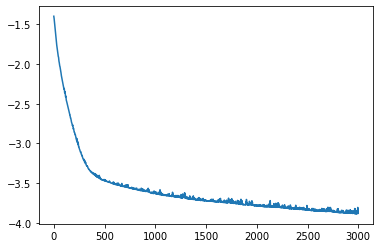

In [95]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1800_A2 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1800_A2, A_star, test_error_1800_A2)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1800_A2), label='test_error_1800_A2')

In [ ]:
#N=500, A=2.1

In [54]:
train_size = int(N*0.25)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.14)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_500_A3 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.123236

Iteration 0 | Training loss: 2.9964473 | Val MSE: 2.6016116 | Test MSE 2.267805
Iteration 500 | Training loss: 0.08187641 | Val MSE: 0.089717455 | Test MSE 0.08785881
Iteration 1000 | Training loss: 0.042355064 | Val MSE: 0.048650574 | Test MSE 0.05032924
Iteration 1500 | Training loss: 0.035020694 | Val MSE: 0.044552445 | Test MSE 0.04616622
Iteration 2000 | Training loss: 0.044459738 | Val MSE: 0.042286787 | Test MSE 0.043809332
Iteration 2500 | Training loss: 0.060805406 | Val MSE: 0.039660126 | Test MSE 0.040292457


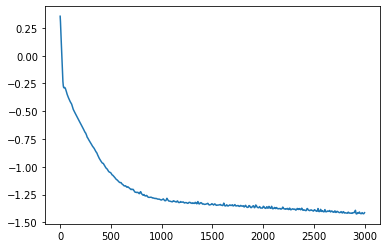

In [55]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_500_A3 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_500_A3, A_star, test_error_500_A3)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_500_A3), label='test_error_500_A3')

In [109]:
#N=800,A=2.1

In [110]:
train_size = 800


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.14)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_800_A3 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.1213486

Iteration 0 | Training loss: 0.58362913 | Val MSE: 0.49468967 | Test MSE 0.49943867
Iteration 500 | Training loss: 0.020342326 | Val MSE: 0.02076266 | Test MSE 0.018265171
Iteration 1000 | Training loss: 0.013142872 | Val MSE: 0.015733497 | Test MSE 0.013982481
Iteration 1500 | Training loss: 0.013208945 | Val MSE: 0.013976257 | Test MSE 0.012443507
Iteration 2000 | Training loss: 0.010455144 | Val MSE: 0.012212748 | Test MSE 0.010874941
Iteration 2500 | Training loss: 0.008663838 | Val MSE: 0.010507462 | Test MSE 0.00946964


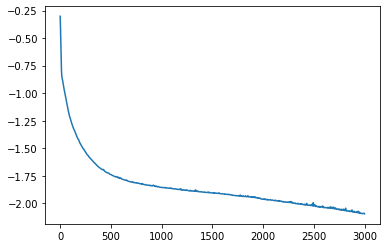

In [111]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_800_A3 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_800_A3, A_star, test_error_800_A3)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_800_A3), label='test_error_800_A3')

In [59]:
#N=1000, A=2.1

In [67]:
train_size = int(N*0.5)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.14)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1000_A3 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.1273026

Iteration 0 | Training loss: 0.54937124 | Val MSE: 0.5293674 | Test MSE 0.5404921
Iteration 500 | Training loss: 0.02740959 | Val MSE: 0.028292412 | Test MSE 0.027597835
Iteration 1000 | Training loss: 0.014146478 | Val MSE: 0.017797424 | Test MSE 0.017317982
Iteration 1500 | Training loss: 0.02495247 | Val MSE: 0.014944895 | Test MSE 0.015021317
Iteration 2000 | Training loss: 0.013157932 | Val MSE: 0.013324106 | Test MSE 0.013237463
Iteration 2500 | Training loss: 0.013417804 | Val MSE: 0.011764486 | Test MSE 0.011758727


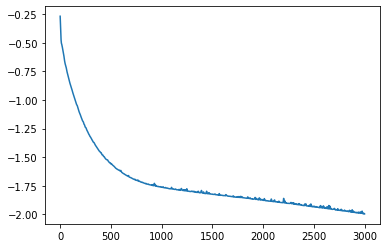

In [68]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1000_A3 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1000_A3, A_star, test_error_1000_A3)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1000_A3), label='test_error_1000_A3')

In [ ]:
#N=1500, A=2.1

In [87]:
train_size = int(N*0.3)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.14)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1500_A3 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.1167896

Iteration 0 | Training loss: 0.0814527 | Val MSE: 0.099865526 | Test MSE 0.104498535
Iteration 500 | Training loss: 0.0011956068 | Val MSE: 0.0022883532 | Test MSE 0.0020294762
Iteration 1000 | Training loss: 0.0014250617 | Val MSE: 0.0018051127 | Test MSE 0.0015548505
Iteration 1500 | Training loss: 0.00089528953 | Val MSE: 0.0015477309 | Test MSE 0.0013080173
Iteration 2000 | Training loss: 0.0008448476 | Val MSE: 0.0013684956 | Test MSE 0.001125622
Iteration 2500 | Training loss: 0.0008497286 | Val MSE: 0.0012179256 | Test MSE 0.000994374


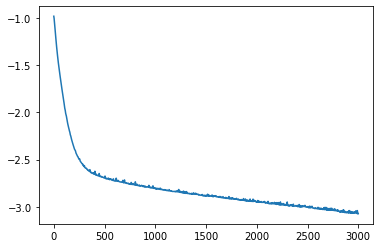

In [88]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1500_A3 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1500_A3, A_star, test_error_1500_A3)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1500_A3), label='test_error_1500_A3')

In [ ]:
#N=1800, A=2.1

In [89]:
train_size = int(N*0.6)


batch_size = 50
random.seed(time.time())
test_index = set(range(N))
train_index = set(random.sample(test_index, train_size))
index_batch = set(random.sample(train_index, batch_size))
train_mask = createMask(index_batch, N)
test_index.difference_update(train_index)


val_size = int((N - train_size) / 2)
val_index = set(random.sample(test_index, val_size))
test_index.difference_update(val_index)

val_mask = createMask(val_index, N)
test_mask = createMask(test_index, N)
node_features = generateX(mu, sigma, N, d)
node_features = node_features.astype('float32')
X = node_features

adj_matrix = generateAdj(N, 0.8, 0.14)
norm_adj_matrix = generate_norm_adj_matrix(adj_matrix)
A_star = norm_adj_matrix


alpha = 10
node_labels_1800_A3 = generate_data(A_star, X, W, V, C, alpha)
colsums = []
for i in np.arange(N):
    v = np.sum(np.abs(A_star[:, i]))
    colsums.append(v)
np.max(colsums)

2.1161716

Iteration 0 | Training loss: 0.17401935 | Val MSE: 0.14315118 | Test MSE 0.14307001
Iteration 500 | Training loss: 0.0008497139 | Val MSE: 0.0011672815 | Test MSE 0.0009732508
Iteration 1000 | Training loss: 0.0007795284 | Val MSE: 0.0008260692 | Test MSE 0.0007277773
Iteration 1500 | Training loss: 0.0006397123 | Val MSE: 0.0006143727 | Test MSE 0.00056393957
Iteration 2000 | Training loss: 0.0002838257 | Val MSE: 0.0005144686 | Test MSE 0.0004877258
Iteration 2500 | Training loss: 0.00030900395 | Val MSE: 0.0004420753 | Test MSE 0.00038105084


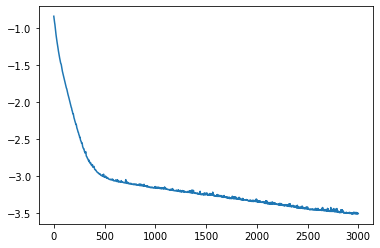

In [90]:
hidden_units_1 = m
hidden_units_2 = m
layer_1 = tf.keras.layers.Dense(units=hidden_units_1, kernel_initializer=initializers.glorot_normal())
layer_2 = tf.keras.layers.Dense(units=hidden_units_2, kernel_initializer=initializers.glorot_normal())# hidden layer: apply weights
out = layers.Dense(K, kernel_initializer=initializers.random_normal(mean=0.0,stddev=1)
                       ,kernel_regularizer=None)  # K (2) classes for nodes

def gnn(node_features, adj_matrix, transform, activation):
    # weight first, then aggregate neighbor features
    #weighted_features = transform(node_features) # apply weights to node features
    #aggregated_features = tf.matmul(adj_matrix, weighted_features) # aggregated neighbor node features
    #return activation(aggregated_features) # apply activation function
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, tf.cast(node_features, dtype=tf.float32)) # aggregated neighbor node features
    weighted_features = transform(aggregated_features) # apply weights to node features
    return activation(weighted_features) # apply activation function

def cora_gnn(node_features, adj_matrix):
    hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
    hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
    # hidden_2 = layers.Dropout(rate=0.4)(hidden_2)
    # logits = gnn(hidden, adj_matrix, layer_2, tf.identity)
    added12 = tf.keras.layers.Add()([hidden_1, hidden_2])
    logits = tf.identity(out(added12))
    # logits = tf.identity(out(hidden_2))
    return logits

learning_rate = 1
test_error_1800_A3 = []
epochs = 3000
for epoch in range(epochs):
    run_optimization(node_features, node_labels_1800_A3, A_star, test_error_1800_A3)
    if epoch % 500 == 0:
        learning_rate = learning_rate * 0.9
fig, ax = plt.subplots()
line1, = ax.plot(np.log10(test_error_1800_A3), label='test_error_1500_A3')

In [118]:
# output

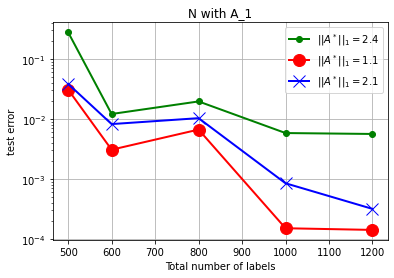

In [124]:
N1 = [ 500, 600, 800, 1000, 1200]
test_A1 = [np.mean(test_error_500_A1[-100:-1]),np.mean(test_error_800_A1[-100:-1]),np.mean(test_error_1000_A1[-100:-1]),test_error_1500_A1[-1],np.mean(test_error_1800_A1[-100:-1])]
test_A2 = [np.mean(test_error_500_A2[-100:-1]),np.mean(test_error_800_A2[-100:-1]),np.mean(test_error_1000_A2[-100:-1]),test_error_1500_A2[-1],np.mean(test_error_1800_A2[-1])]
test_A3 = [np.mean(test_error_500_A3[-100:-1]),np.mean(test_error_800_A3[-100:-1]),np.mean(test_error_1000_A3[-100:-1]),test_error_1500_A3[-1],np.mean(test_error_1800_A3[-100:-1])]
fig, ax = plt.subplots()

line1, = ax.plot(N1, test_A1, label=r'$||A^*||_1=2.4$',color='g', marker='.', markevery=1, linewidth=2, markersize=12)
line2, = ax.plot(N1, test_A2, label=r'$||A^*||_1=1.1$',color='r', marker='o', markevery=1, linewidth=2, markersize=12)
line3, = ax.plot(N1, test_A3, label=r'$||A^*||_1=2.1$',color='b', marker='x', markevery=1, linewidth=2, markersize=12)

ax.set(xlabel='Total number of labels', ylabel='test error', title='N with A_1')
ax.grid()
ax.legend()
plt.yscale('log')
plt.savefig('N with A_1')
plt.show()


In [98]:
print(np.abs(test_A1))

[0.27742592 0.01957997 0.00583006 0.00562957]


In [99]:
print(np.abs(test_A2))

[0.03080781 0.00666026 0.00015192 0.00014248]


In [100]:
print(np.abs(test_A3))

[0.03838862 0.01031488 0.00085093 0.00031878]


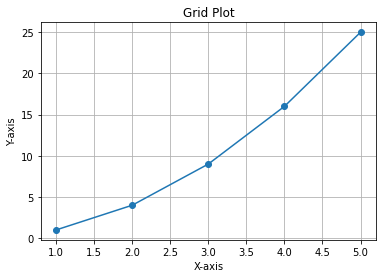

In [125]:
import matplotlib.pyplot as plt

# 创建数据
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

# 创建网格图
plt.plot(x, y, 'o-')

# 设置网格线
plt.grid(True)

# 添加标题和轴标签
plt.title('Grid Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 显示图形
plt.show()


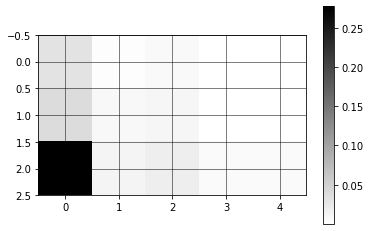

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# 创建数据
data = np.array([test_A2,
                 test_A3,
                 test_A1
                 ])

# 创建网格图
plt.imshow(data, cmap='binary')

# 设置网格线
plt.grid(True, color='black', linewidth=0.5)

# 添加颜色条
plt.colorbar()

# 显示图形
plt.show()


In [129]:
1.1**4

1.4641000000000004

In [130]:
2.1**4

19.448100000000004

In [131]:
test_A1 = [np.mean(test_error_500_A1[-100:-1]),np.mean(test_error_800_A1[-100:-1]),np.mean(test_error_1000_A1[-100:-1]),test_error_1500_A1[-1],np.mean(test_error_1800_A1[-100:-1])]
test_A2 = [np.mean(test_error_500_A2[-100:-1]),np.mean(test_error_800_A2[-100:-1]),np.mean(test_error_1000_A2[-100:-1]),test_error_1500_A2[-1],np.mean(test_error_1800_A2[-1])]
test_A3 = [np.mean(test_error_500_A3[-100:-1]),np.mean(test_error_800_A3[-100:-1]),np.mean(test_error_1000_A3[-100:-1]),test_error_1500_A3[-1],np.mean(test_error_1800_A3[-100:-1])]


33.1776

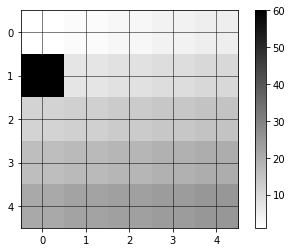

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# 创建数据
data = np.array([[1, 2, 3, 4, 5],
                 [60, 7, 8, 9, 10],
                 [11, 12, 13, 14, 15],
                 [16, 17, 18, 19, 20],
                 [21, 22, 23, 24, 25]])

# 创建网格图
plt.imshow(data, cmap='binary')

# 设置网格线
plt.grid(True, color='black', linewidth=0.5)

# 添加颜色条
plt.colorbar()

# 显示图形
plt.show()


AttributeError: 'list' object has no attribute 'shape'